In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
import numpy as np
import pydot
import pygraphviz
from networkx.drawing.nx_pydot import graphviz_layout
layout = graphviz_layout
%matplotlib inline

In [2]:
DATA_DIR = "data/"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename)) 

In [4]:
df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)

df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
df_calls.loc[df_calls['duration']<0]=0

df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)


df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
df_facebook_friends.rename(columns={'# user_a':'user_a'},inplace=True)


df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
df_genders.rename(columns={'# user':'user_a'},inplace=True)


In [5]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph()

In [6]:
def make_graph(df, start_time=None,end_time=None):
    G= nx.Graph()
    if start_time is not None:
        in_study_users_at_timestamp = df[(start_time>0)&(df["# timestamp"]>=start_time )& (df["# timestamp"]<end_time)& (df["user_b"]>=0)][["user_a","user_b","rssi"]]
        for row in in_study_users_at_timestamp.itertuples():
            user_a = row[1]
            user_b = row[2]
            if len(row) >3:
                rssi = row[3]
                G.add_edge(user_a,user_b, weight= rssi)
            else:
                G.add_edge(user_a,user_b)
    else:
        for row in df.itertuples():
            user_a = row[1]
            user_b = row[2]
            G.add_edge(user_a,user_b)    
    return G

Text(0, 0.5, 'number of edges')

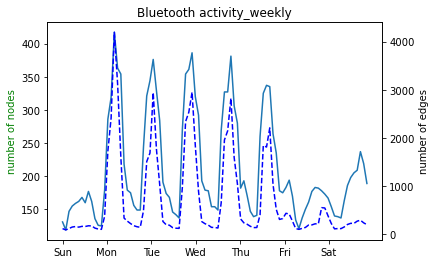

In [7]:
graph_bt = [make_graph(df_bt,(i+1)*24*60*5,(i+2)*24*60*5)for i in range(28*12)]
nodes=([nx.number_of_nodes(graph_bt[i]) for i in range(8*12)])
edges=([nx.number_of_edges(graph_bt[i]) for i in range(8*12)])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.xticks(np.arange(0,8*12,8*12/7), ('Sun', 'Mon', 'Tue', 'Wed', 'Thu','Fri','Sat'))
plt.title("Bluetooth activity_weekly")
ax1.plot(nodes[1:8*12])
ax2.plot(edges[1:8*12],linestyle='dashed', color='b')
ax1.set_ylabel('number of nodes', color='g')
ax2.set_ylabel('number of edges')

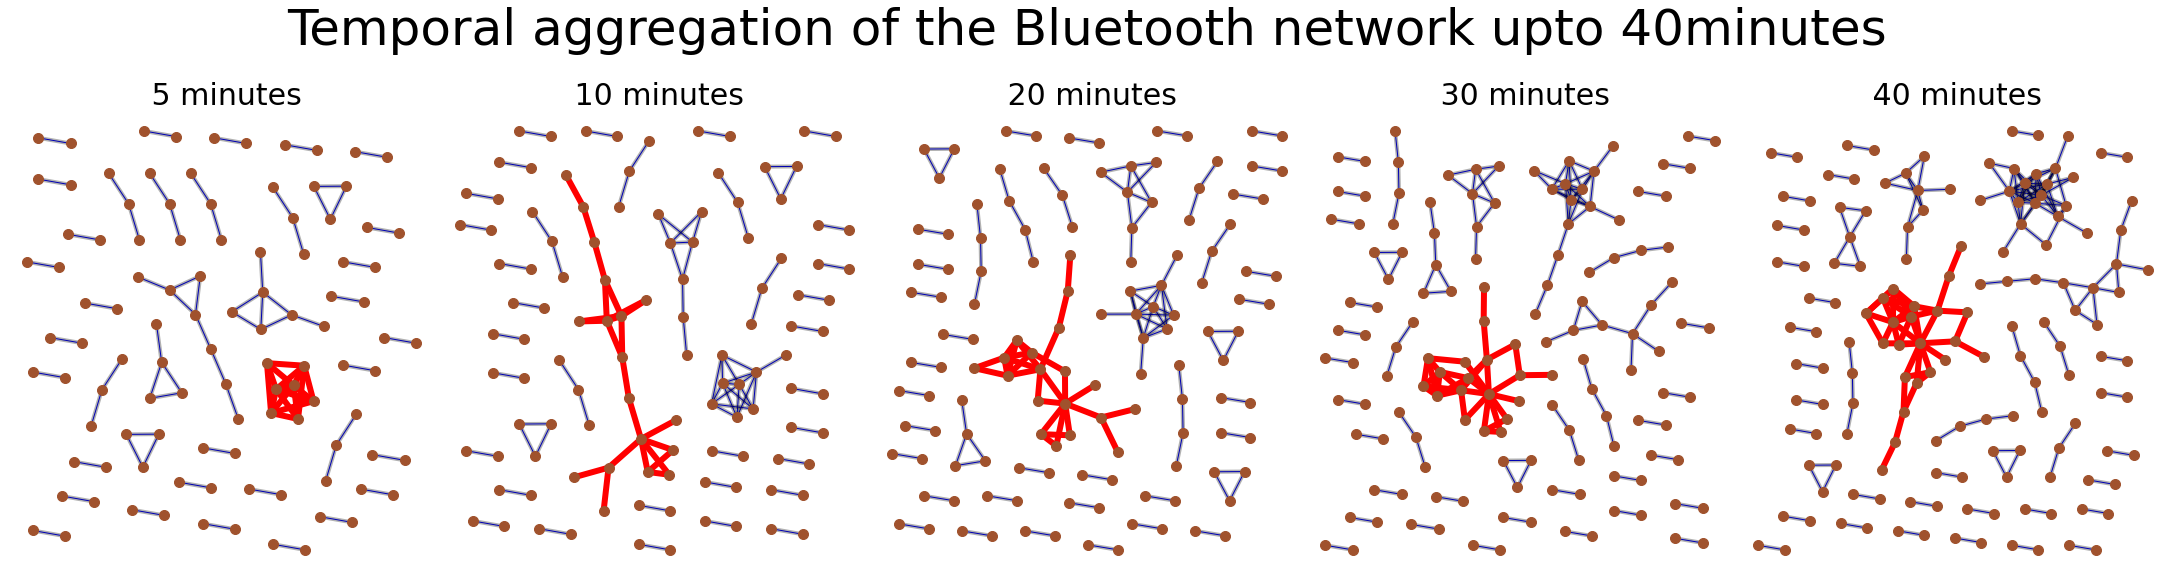

In [9]:
plt.figure(figsize=(30,8))
plt.suptitle("Temporal aggregation of the Bluetooth network upto 40minutes", fontsize=50)
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.8, wspace=0.01, hspace=0.01)
time_span=[2,3,5,7,9]
# time_span=[1,2,4,6,8]
j=1
for i in time_span:  
    #graph = make_graph(df_bt,2*2*8*60,2*2*8*60*i)
    graph = make_graph(df_bt,3*7*1*60*1,3*7*1*60*i)
    plt.subplot(1,5,j)
    plt.title(" %d minutes" % ((i-1)*5), fontsize=30)
    j+=1
    pos = graphviz_layout(graph,prog='neato')
    nx.draw(graph, pos,
            with_labels=False,                        edge_color='b',
            node_size=100,node_color='#A0522D'
           )
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    G0 = graph.subgraph(Gcc[0])
    nx.draw_networkx_edges(G0,pos,node_size=100, edge_color='r',node_color='r', width=6.0)       
    for Gi in Gcc[1:]:
        if len(Gi) > 1:
            nx.draw_networkx_edges(graph.subgraph(Gi), pos,node_size=100, alpha=0.3,
                                  width=4.0)
plt.show()